# Market states by Hidden Markov Models

code based on https://inovancetech.com/hmm-tutorial-1.html

In [1]:
library(tidyverse)
library(tidyquant)
library(depmixS4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last



Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend


Loading r

## Load data

In [3]:
tbl <- read_csv("data/EURUSD1d.csv") %>%
    rename(date = `Open Timestamp`,
           open = Open,
           high = High,
           low = Low,
           close = Close) %>%
    mutate(date = as_datetime(date))
tbl[1:5,]

Parsed with column specification:
cols(
  `Open Timestamp` = col_character(),
  Open = col_double(),
  High = col_double(),
  Low = col_double(),
  Close = col_double()
)



date,open,high,low,close
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
2012-01-03,1.29357,1.30760,1.29343,1.30528
2012-01-04,1.30528,1.30718,1.28967,1.29295
2012-01-05,1.29295,1.29427,1.27688,1.27905
2012-01-06,1.27905,1.28116,1.26961,1.27136
2012-01-08,1.27136,1.27136,1.26649,1.26778


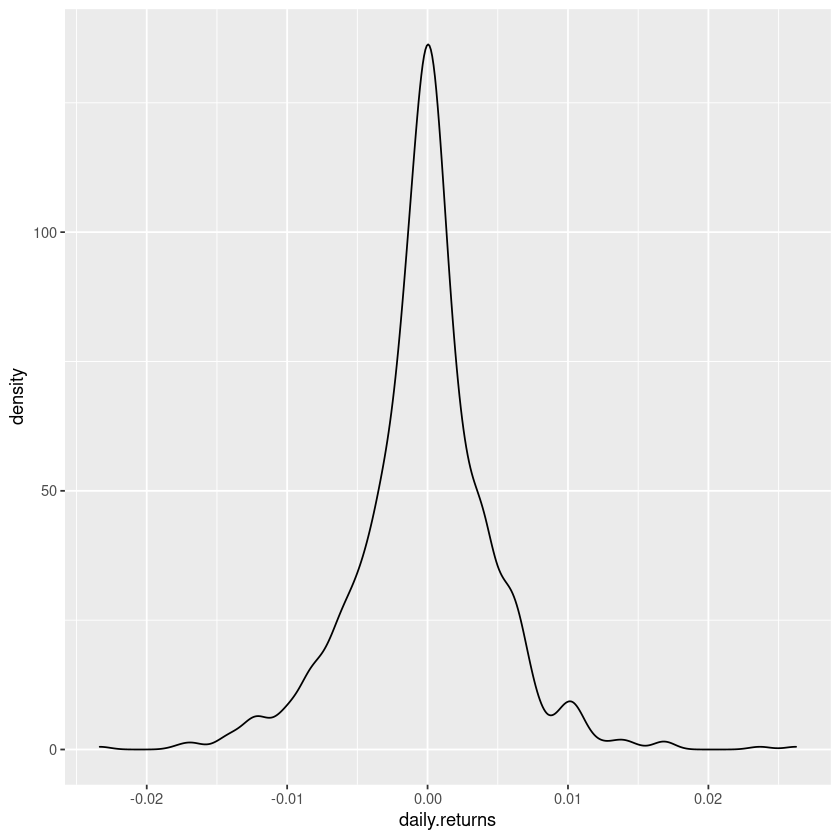

In [4]:
daily_log_returns <- tbl %>%
    tq_transmute(select = close,
                 mutate_fun = periodReturn,
                 period = "daily",
                 type = "log")
daily_log_returns %>%
    ggplot(aes(x = daily.returns)) +
    geom_density()

Warning message:
“Removed 14 row(s) containing missing values (geom_path).”


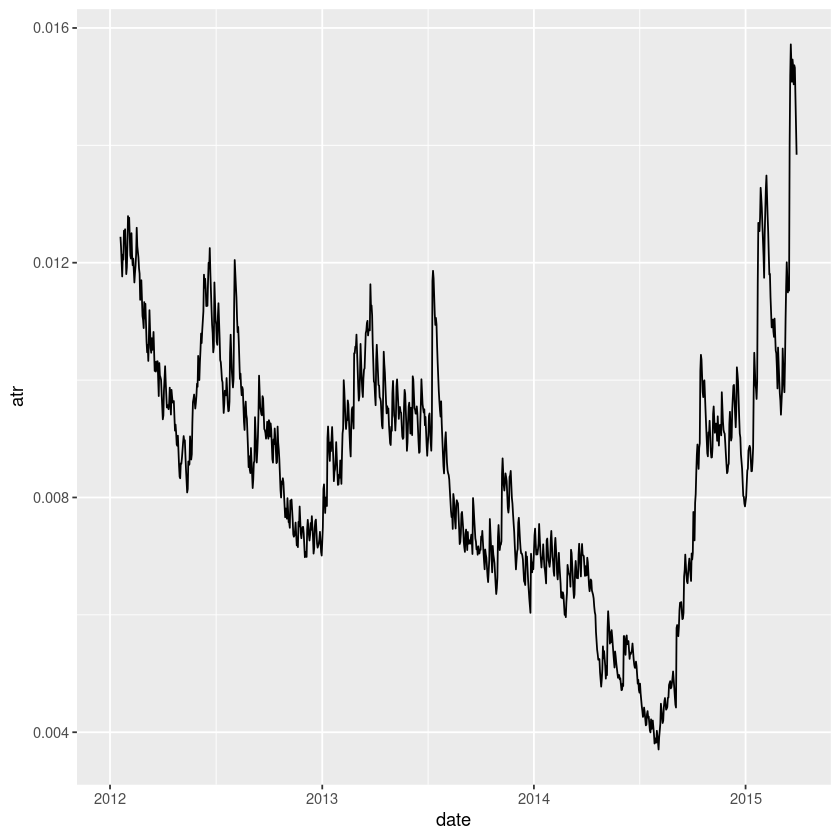

In [7]:
atr14 <- tbl %>%
    tq_transmute(select = c(high, low, close),
                 mutate_fun = ATR,
                 n = 14)
atr14 %>%
    ggplot(aes(x = date, y = atr)) +
    geom_line()

In [8]:
atr14 <- daily_log_returns %>%
    left_join(atr14, by = "date") %>%
    drop_na()
atr14[1:10,]

date,daily.returns,tr,atr,trueHigh,trueLow
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012-01-19,0.0075360408,0.01330,0.01244214,1.29711,1.28381
2012-01-20,-0.0025263367,0.00994,0.01226342,1.29853,1.28859
2012-01-22,-0.0032387061,0.00530,0.01176603,1.29273,1.28743
2012-01-23,0.0106681264,0.01698,0.01213846,1.30515,1.28817
2012-01-24,0.0007752087,0.01094,0.01205285,1.30617,1.29523
2012-01-25,0.0054554841,0.01895,0.01254551,1.31194,1.29299
2012-01-26,-0.0013820963,0.00960,0.01233511,1.31830,1.30870
2012-01-27,0.0094985675,0.01562,0.01256975,1.32327,1.30765
2012-01-29,-0.0004618116,0.00188,0.01180619,1.32234,1.32046


In [9]:
hmm_model <- depmix(response = list(daily.returns ~ 1, atr ~ 1),
                    family = list(gaussian(), gaussian()),
                    data = atr14,
                    nstates = 3)
hmm_fit <- fit(hmm_model)

converged at iteration 27 with logLik: 9503.258 


In [10]:
summary(hmm_fit)

Initial state probabilities model 
pr1 pr2 pr3 
  0   1   0 

Transition matrix 
        toS1  toS2  toS3
fromS1 0.990 0.007 0.003
fromS2 0.004 0.996 0.000
fromS3 0.008 0.000 0.992

Response parameters 
Resp 1 : gaussian 
Resp 2 : gaussian 
    Re1.(Intercept) Re1.sd Re2.(Intercept) Re2.sd
St1               0  0.004           0.007  0.001
St2               0  0.006           0.010  0.001
St3               0  0.002           0.005  0.001


In [25]:
hmm_post <- posterior(hmm_fit) %>%
    mutate(date = tbl$date[-(1:14)]) %>%
    pivot_longer(cols = -c(date, state))

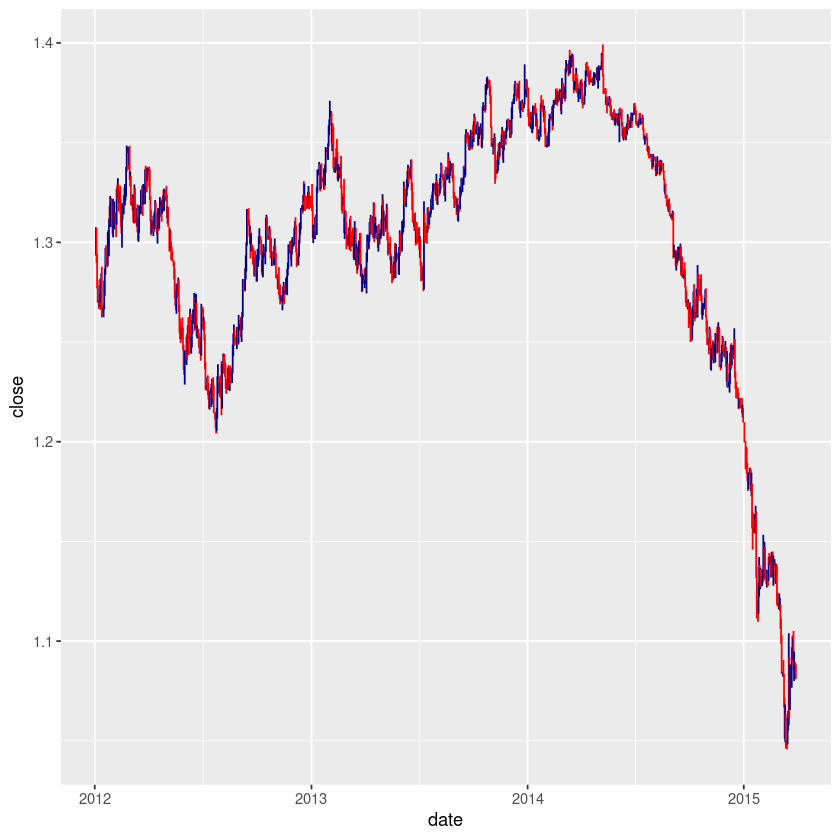

In [26]:
tbl %>%
    ggplot(aes(x = date, y = close)) +
    geom_barchart(aes(open = open, high = high, low = low, close = close))

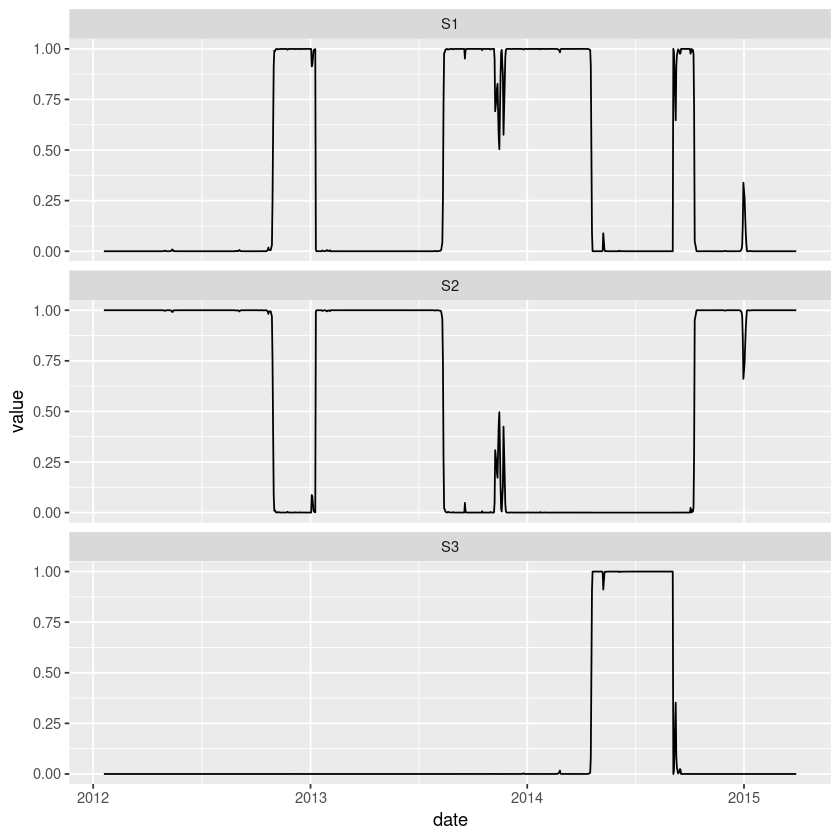

In [27]:
hmm_post %>%
    ggplot(aes(x = date, y = value, group = name)) +
    geom_line() +
    facet_wrap(~ name, ncol = 1)